# DAT-ATX-1 Capstone Project

## 3. Dimensionality Reduction

For the final part of this project, we will extend our study of **text classification**. Using Principal Component Analysis and Truncated Singular Value Decomposition (methods for dimensionality reduction) we will attempt to replicate the same quality of modeling with a fraction of the features.

The outline of the procedure we are going to follow is:

- Turn a corpus of text documents (restaurant names, street addresses) into **feature vectors** using a **Bag of Words** representation,
- We will apply Principal Component Analysis to decompose the feature vectors into "simpler," meaningful pieces.
- Dimensionality reduction is frequently performed as a pre-processing step before another learning algorithm is applied.

**Motivations**

- The number of features in our dataset can be difficult to manage, or even misleading (e.g. if the relationships are actually simpler than they appear).
- reduce computational expense
- reduce susceptibility to overfitting
- reduce noise in the dataset
- enhance our intuition

### 0. Import libraries & packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats

import seaborn as sns
sns.set(rc={"axes.labelsize": 15});

# Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 10, 7.5;
plt.rcParams['axes.grid'] = True;
plt.gray();

### 1. Import dataset

In [3]:
#Reading the dataset in a dataframe using Pandas
df = pd.read_csv("data.csv")  

#Print first observations
df.head() 

,Facility_ID,Restaurant_Name,Inspection_Date,Process_Description,Geocode,Street,City,Zip_Code,Score,Latitude,...,Letter_Grade,Area_NE Austin,Area_NW Austin,Area_SE Austin,Area_SW Austin,Status_Pass,Grade_B,Grade_C,Grade_F,Pristine
0,2801996,Mr. Gatti's #118,2015-12-23,Routine Inspection,"2121 W PARMER LN, AUSTIN, TX 78758",2121 W PARMER LN,AUSTIN,78758,94,30.415649,...,A,0,1,0,0,1,0,0,0,1
1,10001712,Texaco Braker Mart,2015-12-23,Routine Inspection,"2601 W BRAKER LN, AUSTIN, TX 78758",2601 W BRAKER LN,AUSTIN,78758,83,30.390269,...,B,0,1,0,0,1,1,0,0,0
2,10385802,Subway,2015-12-23,Routine Inspection,"2501 W PARMER LN, AUSTIN, TX 78758",2501 W PARMER LN,AUSTIN,78758,98,30.418236,...,A,0,1,0,0,1,0,0,0,1
3,2802274,Baskin Robbins,2015-12-23,Routine Inspection,"12407 N MOPAC EXPY, AUSTIN, TX 78758",12407 N MOPAC EXPY,AUSTIN,78758,99,30.417462,...,A,0,1,0,0,1,0,0,0,1
4,10964220,JR's Tacos,2015-12-22,Routine Inspection,"1921 CEDAR BEND DR, AUSTIN, TX 78758",1921 CEDAR BEND DR,AUSTIN,78758,91,30.408322,...,A,0,1,0,0,1,0,0,0,1


In [4]:
df.columns

Index([u'Facility_ID', u'Restaurant_Name', u'Inspection_Date',
       u'Process_Description', u'Geocode', u'Street', u'City', u'Zip_Code',
       u'Score', u'Latitude', u'Longitude', u'Area', u'Status',
       u'Letter_Grade', u'Area_NE Austin', u'Area_NW Austin',
       u'Area_SE Austin', u'Area_SW Austin', u'Status_Pass', u'Grade_B',
       u'Grade_C', u'Grade_F', u'Pristine'],
      dtype='object')

Our first collection of feature vectors will come from the Restaurant_Name column. We are still trying to predict whether a restaurant falls under the "pristine" category (Grade A, score greater than 90) or not. We could also try to see whether we could predict a restaurant's grade (A, B, C or F)

### 2. Dimensionality Reduction Techniques

#### Restaurant Names as a Bag-of-words model

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

# Turn the text documents into vectors

vectorizer = CountVectorizer(min_df=1, stop_words="english")

X = vectorizer.fit_transform(df['Restaurant_Name']).toarray()
y = df['Letter_Grade']

target_names = y.unique()


In [6]:
# Train/Test split and cross validation:

from sklearn import cross_validation

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, train_size = 0.8)

In [7]:
X_train.shape

(14888, 3430)

Even though we do not have more features (3430) than rows of data (14888), we can still attempt to reduce the feature space by using Truncated SVD:

#### Truncated Singular Value Decomposition  for Dimensionality Reduction

Once we have extracted a vector representation of the data, it's a good idea to project the data on the first 2D of a Singular Value Decomposition (i.e.. Principal Component Analysis) to get a feel of the data. Note that the TruncatedSVD class can accept scipy.sparse matrices as input (as an alternative to numpy arrays). We will use it to visualize the first two principal components of the vectorized dataset.

In [8]:
from sklearn.decomposition import TruncatedSVD

svd_two = TruncatedSVD(n_components=2, random_state=42)

X_train_svd = svd_two.fit_transform(X_train)

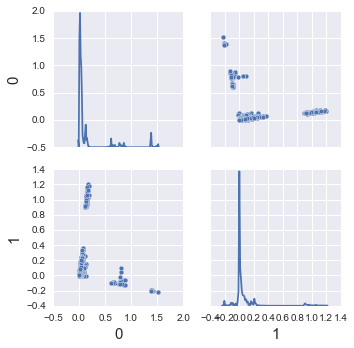

In [9]:
pc_df = pd.DataFrame(X_train_svd)  # cast resulting matrix as a data frame
sns.pairplot(pc_df, diag_kind='kde');

In [10]:
# Percentage of variance explained for each component

def pca_summary(pca):
    return pd.DataFrame([np.sqrt(pca.explained_variance_), 
              pca.explained_variance_ratio_, 
              pca.explained_variance_ratio_.cumsum()],
             index = ["Standard deviation", "Proportion of Variance", "Cumulative Proportion"], 
             columns = (map("PC{}".format, range(1, len(pca.components_)+1))))

In [11]:
pca_summary(svd_two)

,PC1,PC2
Standard deviation,0.219172,0.212968
Proportion of Variance,0.017896,0.016897
Cumulative Proportion,0.017896,0.034794


In [12]:
# Only 3.5% of the variance is explained in the data
svd_two.explained_variance_ratio_.sum()

0.034793886658388021

In [13]:
from itertools import cycle

def plot_PCA_2D(data, target, target_names):
    colors = cycle('rgbcmykw')
    target_ids = range(len(target_names))
    plt.figure()
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(data[target == i, 0], data[target == i, 1],
                   c=c, label=label)
    plt.legend()

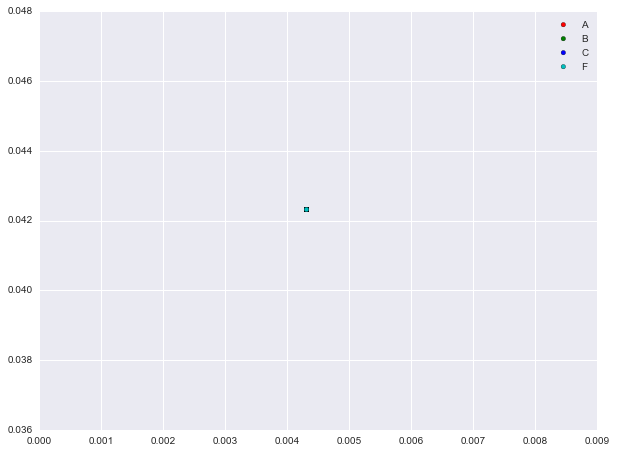

In [14]:
plot_PCA_2D(X_train_svd, y_train, target_names)

This must be the most uninformative plot in the history of plots. Obviously 2 principal components aren't enough. Let's try with 100:

In [15]:
# Now, let's try with 100 components to see how much it explains
svd_hundred = TruncatedSVD(n_components=100, random_state=42)
X_train_svd_hundred = svd_hundred.fit_transform(X_train)

In [16]:
# 43.7% of the variance is explained in the data for 100 dimensions
# This is mostly due to the High dimension of data and sparcity of the data
svd_hundred.explained_variance_ratio_.sum()

0.4371657569213736

<Container object of 100 artists>

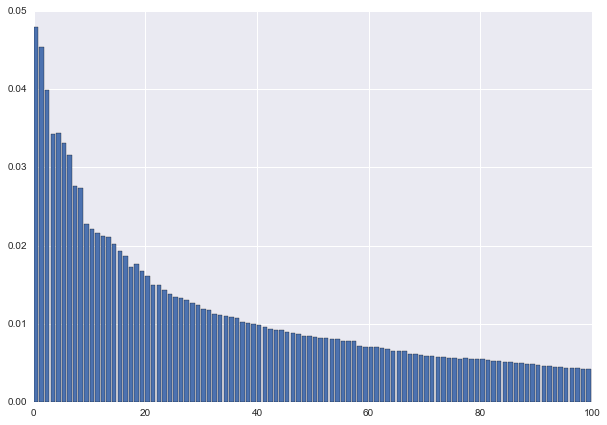

In [17]:
plt.figure(figsize=(10, 7))
plt.bar(range(100), svd_hundred.explained_variance_)

Is it worth it to keep adding dimensions? Recall that we started with a 3430-dimensional feature space which we have already reduced to 100 dimensions, and according to the graph above each dimension over the 100th one will be adding less than 0.5% in our explanation of the variance. Let us try once more with 300 dimensions, to see if we can get something respectably over 50% (so we can be sure we are doing better than a coin toss) 

In [18]:
svd_sparta = TruncatedSVD(n_components=300, random_state=42)

X_train_svd_sparta = svd_sparta.fit_transform(X_train)

In [19]:
X_test_svd_sparta = svd_sparta.fit_transform(X_test)

In [20]:
svd_sparta.explained_variance_ratio_.sum()

0.66753272789796669

66.2% of the variance is explained through our model. This is quite respectable.

<Container object of 300 artists>

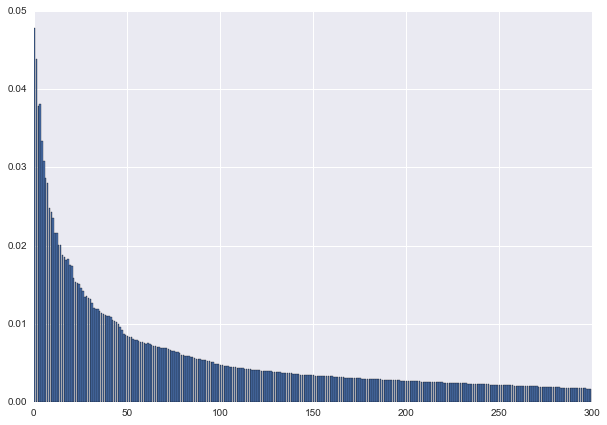

In [21]:
plt.figure(figsize=(10, 7))
plt.bar(range(300), svd_sparta.explained_variance_)

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import cross_validation
from sklearn.naive_bayes import MultinomialNB

# Fit a classifier on the training set

classifier = MultinomialNB().fit(np.absolute(X_train_svd_sparta), y_train)
print("Training score: {0:.1f}%".format(
    classifier.score(X_train_svd_sparta, y_train) * 100))

# Evaluate the classifier on the testing set

print("Testing score: {0:.1f}%".format(
    classifier.score(X_test_svd_sparta, y_test) * 100))

Training score: 66.1%
Testing score: 64.3%


#### Restaurant Streets as a Bag-of-words model

In [23]:
streets = df['Geocode'].apply(pd.Series)

In [24]:
streets = df['Geocode'].tolist()

In [25]:
split_streets = [i.split(' ', 1)[1] for i in streets]

In [26]:
split_streets = [i.split(' ', 1)[1] for i in split_streets]

In [27]:
split_streets = [i.split(' ', 1)[0] for i in split_streets]

In [28]:
split_streets[0]

'PARMER'

In [29]:
import re
shortword = re.compile(r'\W*\b\w{1,3}\b')

In [30]:
for i in range(len(split_streets)):
    split_streets[i] = shortword.sub('', split_streets[i])

In [31]:
# Create a new column with the street:
df['Street_Words'] = split_streets

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

# Turn the text documents into vectors

vectorizer = CountVectorizer(min_df=1, stop_words="english")

X = vectorizer.fit_transform(df['Street_Words']).toarray()
y = df['Letter_Grade']

target_names = y.unique()

In [33]:
# Train/Test split and cross validation:

from sklearn import cross_validation

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, train_size = 0.8)

In [34]:
X_train.shape

(14888, 159)

In [35]:
from sklearn.decomposition import TruncatedSVD

svd_two = TruncatedSVD(n_components=2, random_state=42)

X_train_svd = svd_two.fit_transform(X_train)

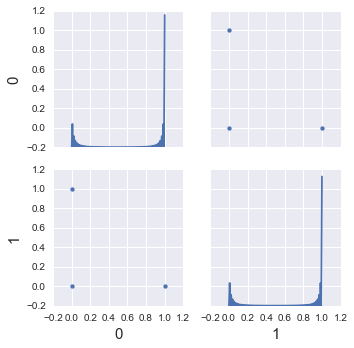

In [36]:
pc_df = pd.DataFrame(X_train_svd)  # cast resulting matrix as a data frame
sns.pairplot(pc_df, diag_kind='kde');

In [37]:
pca_summary(svd_two)

,PC1,PC2
Standard deviation,0.260596,0.257827
Proportion of Variance,0.126940,0.124256
Cumulative Proportion,0.126940,0.251196


In [38]:
# 25% of the variance is explained in the data when we use only TWO principal components!
svd_two.explained_variance_ratio_.sum()

0.25119574996239152

In [44]:
# Now, let's try with 10 components to see how much it explains
svd_ten = TruncatedSVD(n_components=10, random_state=42)
X_train_svd_ten = svd_ten.fit_transform(X_train)

In [45]:
# 53.9% of the variance is explained in the data for 10 dimensions
# This is mostly due to the High dimension of data and sparcity of the data
svd_ten.explained_variance_ratio_.sum()

0.53886524865969476